In [1]:
%run -i "loaddata.py"
plt.rcParams["font.size"] = 13

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


### The timeseries

In [2]:
all_keys = tuple(data_dict.keys())
keys = [all_keys[i] for i in range(len(all_keys)) if i%2==0]

x = np.array([data_dict[keys[i]][:,0] for i in range(len(keys))])
y = np.array([data_dict[keys[i]][:,1] for i in range(len(keys))])

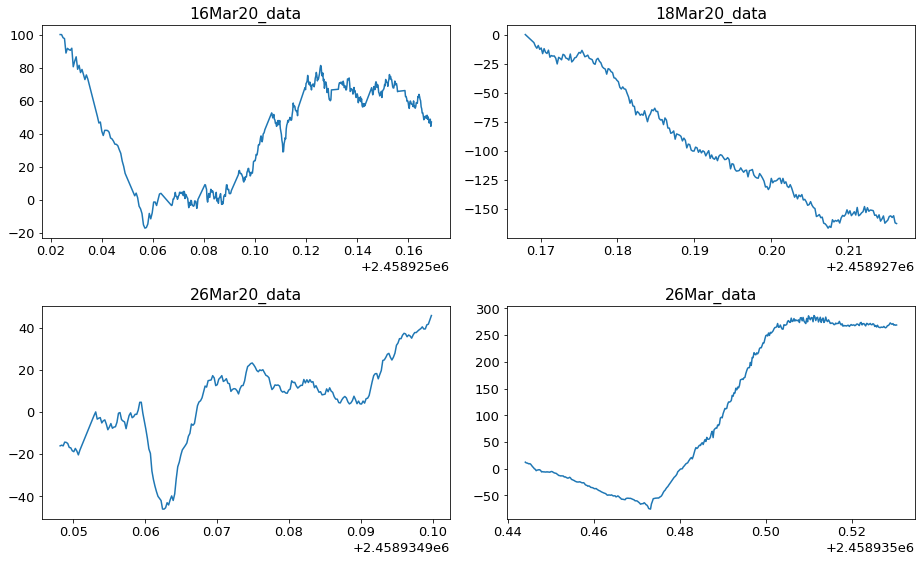

In [3]:
plt.figure(figsize=(13,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(keys[i])
    plt.plot(x[i], y[i])
plt.tight_layout()
plt.show()

### Stacked histograms of feature distributions

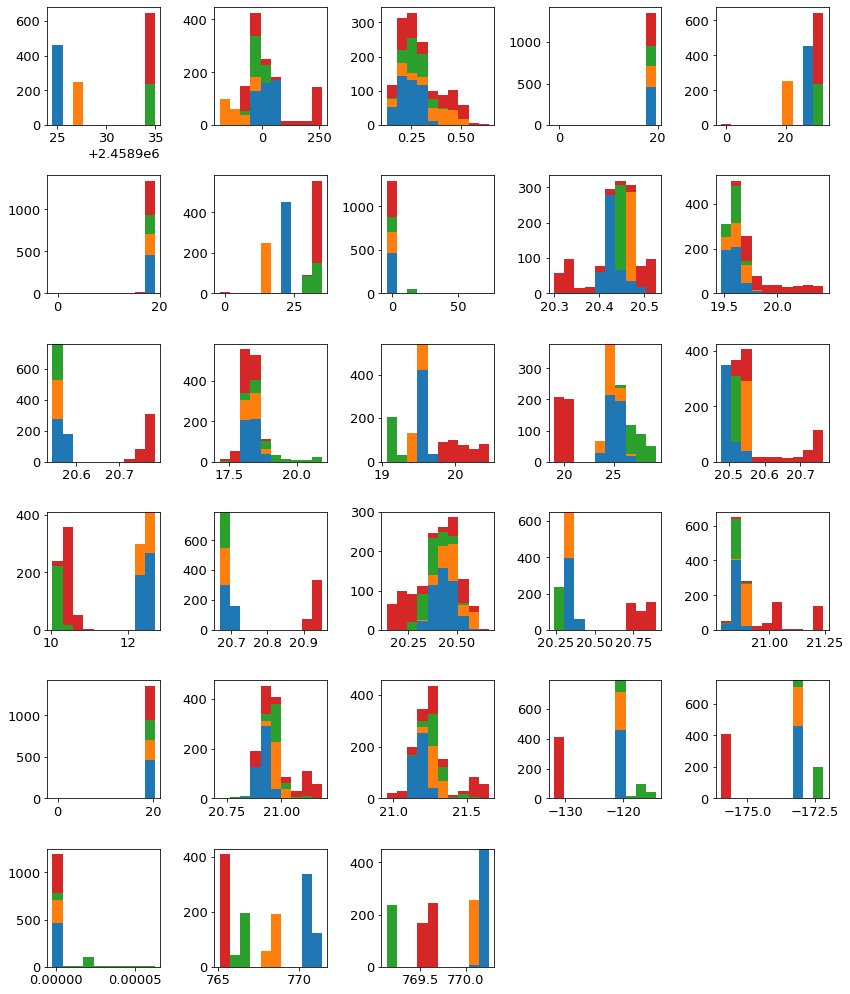

In [11]:
fig = plt.figure(figsize=(12,14))
for i in range( data_dict[keys[0]].shape[1] ):
    plt.subplot(6,5,i+1)
    plt.hist([data_dict[keys[0]][:,i], data_dict[keys[1]][:,i], data_dict[keys[2]][:,i], data_dict[keys[3]][:,i]], 
             histtype='barstacked', align='left')
plt.tight_layout()
plt.show()

fig.savefig("figs/features_hist.pdf")

### t-SNE

In [5]:
from sklearn.manifold import TSNE
# Collect all data in a single array
data = data_dict[keys[0]]
for i in range(1,4):
    data = np.append(data, data_dict[keys[i]],axis=0)
    
y_labels = data[:,1]
X = data[:,3:]

# Remove nan
remove = np.isnan(X)[:,0]
remove1 = [i for i in range(len(remove)) if remove[i]==False]
X = X[remove1,:]
y_labels = y_labels[remove1]

tsne = TSNE(n_components = 2, n_jobs=-1, verbose=0, random_state=42)
tsne_data = tsne.fit_transform(X)

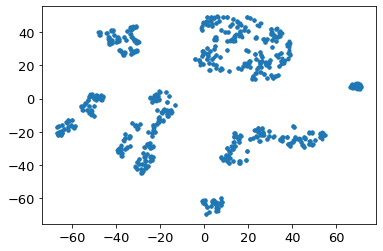

In [6]:
plt.figure()
plt.plot(tsne_data[:,0], tsne_data[:,1],'.')
plt.show()